# 4.1 Predictive Models Using Regression Tree Based Models

After performing ETL and EDA on our data, regression tree based models chosen to predict the destination of our taxi trips. The choice for using regression trees are:

- Regression tree based models are able to predict multinominal outcome variables, which is ideal in our case as our outcome variables consist of two outputs (latitude and longitude)
- Decision boundaries of regression trees are rectilinear which is suitable for geospatial data as it is analogous drawing rectangles on a map to bound coordinates and using the centriod value as our predicted destination coordinates.

Therefore, both Decision Tree Regressor and Random Forest Regressor from sklearn packages will be used. 

To adopt regression models the following steps are carried out:
    1. Drop off features not required for training 
    2. Split our train and val in to X (Predictor variables) and y (outcome variables) respectively
    3. Fit X_train and y_train into a decision tree regressor and grid search for the best parameters
    4. Use the trained model to predict on X_val
    5. Evaluating the performance of our model by calaculating the mean harversine distance between our predictions and actual end coordiantes
    6. Use the best grid search parameters with random forest regressor to improve our results
    7. Chose the best model and use it to predict on our test set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_pickle('./Pickles/train')
val = pd.read_pickle('./Pickles/val')
test = pd.read_pickle('./Pickles/test')

### Features which are not required for training needs to be dropped off:

- TRIP_ID: Each row already indicates that it's a unique trip
- TIMESTAMP: Required datetime features have already been extracted from timestamp
- POLYLINE: Required coordinates already extracted
- date_time: Required day, week and q_hour features have already been extracted from date_time
- DISTANCE: Normalised distance will be used instead
- DURATION: Normalised duration will be used instead

In [3]:
def drop_col(df):
    """
    Dropping columns where features have been extracted
    1. TRIP_ID is actually made up of both TAXI_ID and TIMESTAMP
    2. Extracted all date_time data  
    """
    return df.drop([ u'TRIP_ID', u'TIMESTAMP', u'POLYLINE', u'date_time', u'DISTANCE', u'DURATION'], axis = 1)

In [4]:
train = drop_col(train)
val = drop_col(val)
test = drop_col(test)

In [5]:
print train.shape
print val.shape
print test.shape

(1580976, 28)
(1581, 28)
(320, 26)


### Split our train and val in to X (Predictor variables) and y (outcome variables) respectively

In [6]:
def X_y_split(df):
    """
    Getting independent (X) and dependent (y) variables
    """
    X = df.drop(['END_LAT', 'END_LONG'], axis = 1).reset_index(drop=True)
    y = df.loc[:,['END_LAT', 'END_LONG']].reset_index(drop=True)
    return X, y

In [7]:
X_train, y_train = X_y_split(train)
X_val, y_val = X_y_split(val)

### Fit X_train and y_train into a decision tree regressor and grid search for the best parameters

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
print X_train.shape , y_train.shape
print X_val.shape, y_val.shape

(1580976, 26) (1580976, 2)
(1581, 26) (1581, 2)


In [10]:
print (X_train.shape[0] + X_val.shape[0]) / 80
print (X_train.shape[0] + X_val.shape[0]) / 100
print (X_train.shape[0] + X_val.shape[0]) / 150
print (X_train.shape[0] + X_val.shape[0]) / 250
print (X_train.shape[0] + X_val.shape[0]) / 500

19781
15825
10550
6330
3165


DecisionTreeRegressor hyperparameter, minimum samples to be for a split is chosen to be grid search upon as we would like to determine how many coordinates should fall in a rectiliner boundary. Values 80, 100, 150, 250, 500 are chosen as, if each leave nodes where to contain those amount of coordinates, we will have the amount of clusters printed above.   

In [66]:
dtr_params = {'min_samples_split' : [80, 100, 150, 250, 500]}

dtr_gridsearch = GridSearchCV(DecisionTreeRegressor(random_state=0), dtr_params, cv=5, verbose=1, n_jobs=-1)

dtr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [80, 100, 150, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [67]:
print "Best score after Grid Search: " + str(dtr_gridsearch.best_score_)
print "Best min samples in each leaf node: " + str(dtr_gridsearch.best_params_)

Best score after Grid Search: 0.996837094688
Best min samples in each leaf node: {'min_samples_split': 100}


Gridsearchcv on DecisionTreeRegressor indicated that the best min samples in each leaf node is 100.

In [87]:
dtr = dtr_gridsearch.best_estimator_
dtr_val_pred = dtr.predict(X_val)
dtr_df = pd.DataFrame(data = dtr_val_pred, columns=["LATITUDE", "LONGITUDE"])
dtr_score = pd.concat([dtr_df, y_val],axis=1)

def haversine(start_long, start_lat, end_long, end_lat):
    '''
    Using haversine formula to calculate distance in km
    between two lat,long coordinates.
    '''
    EARTH_RADIUS = 6371 #6,371 km is the approximate distance from Earth's center to its surface 
    start_long = np.radians(start_long)
    start_lat = np.radians(start_lat)
    end_long = np.radians(end_long)
    end_lat = np.radians(end_lat)

    dlong = end_long - start_long
    dlat = end_lat - start_lat

    a = (np.sin(dlat / 2)**2 + np.cos(start_lat) * np.cos(end_lat) *
         np.sin(dlong / 2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return np.nan_to_num(c * EARTH_RADIUS)

dtr_score["SCORE"] = haversine(dtr_score['LATITUDE'],dtr_score['LONGITUDE'], dtr_score['END_LONG'], dtr_score['END_LAT'])

dtr_score['SCORE'] = haversine(dtr_score['LONGITUDE'],dtr_score['LATITUDE'], 
                             dtr_score['END_LONG'], dtr_score['END_LAT'])

In [88]:
print dtr_score['SCORE'].mean()
dtr_score.sort_values("SCORE",ascending=False)

2.26823765707


,LATITUDE,LONGITUDE,END_LAT,END_LONG,SCORE
66,41.108877,-8.595972,41.227920,-8.617527,13.359376
392,41.125122,-8.611929,41.236740,-8.670024,13.329665
1543,41.145220,-8.578248,41.197806,-8.708985,12.407134
490,41.148864,-8.585865,41.237046,-8.670177,12.079505
447,41.236749,-8.669187,41.136921,-8.617482,11.913813
122,41.236749,-8.669187,41.140629,-8.615727,11.586485
911,41.236718,-8.669969,41.142177,-8.616762,11.416395
1070,41.236803,-8.669277,41.147883,-8.608356,11.124143
766,41.236803,-8.669277,41.151078,-8.600796,11.121831
26,41.236803,-8.669277,41.147820,-8.610336,11.055476


After testing on our validation set, the mean harversine distance is ~2.27km which is relatively ok.

Text(0.5,1,u'Histogram of Decision Tree Regressor Performance')

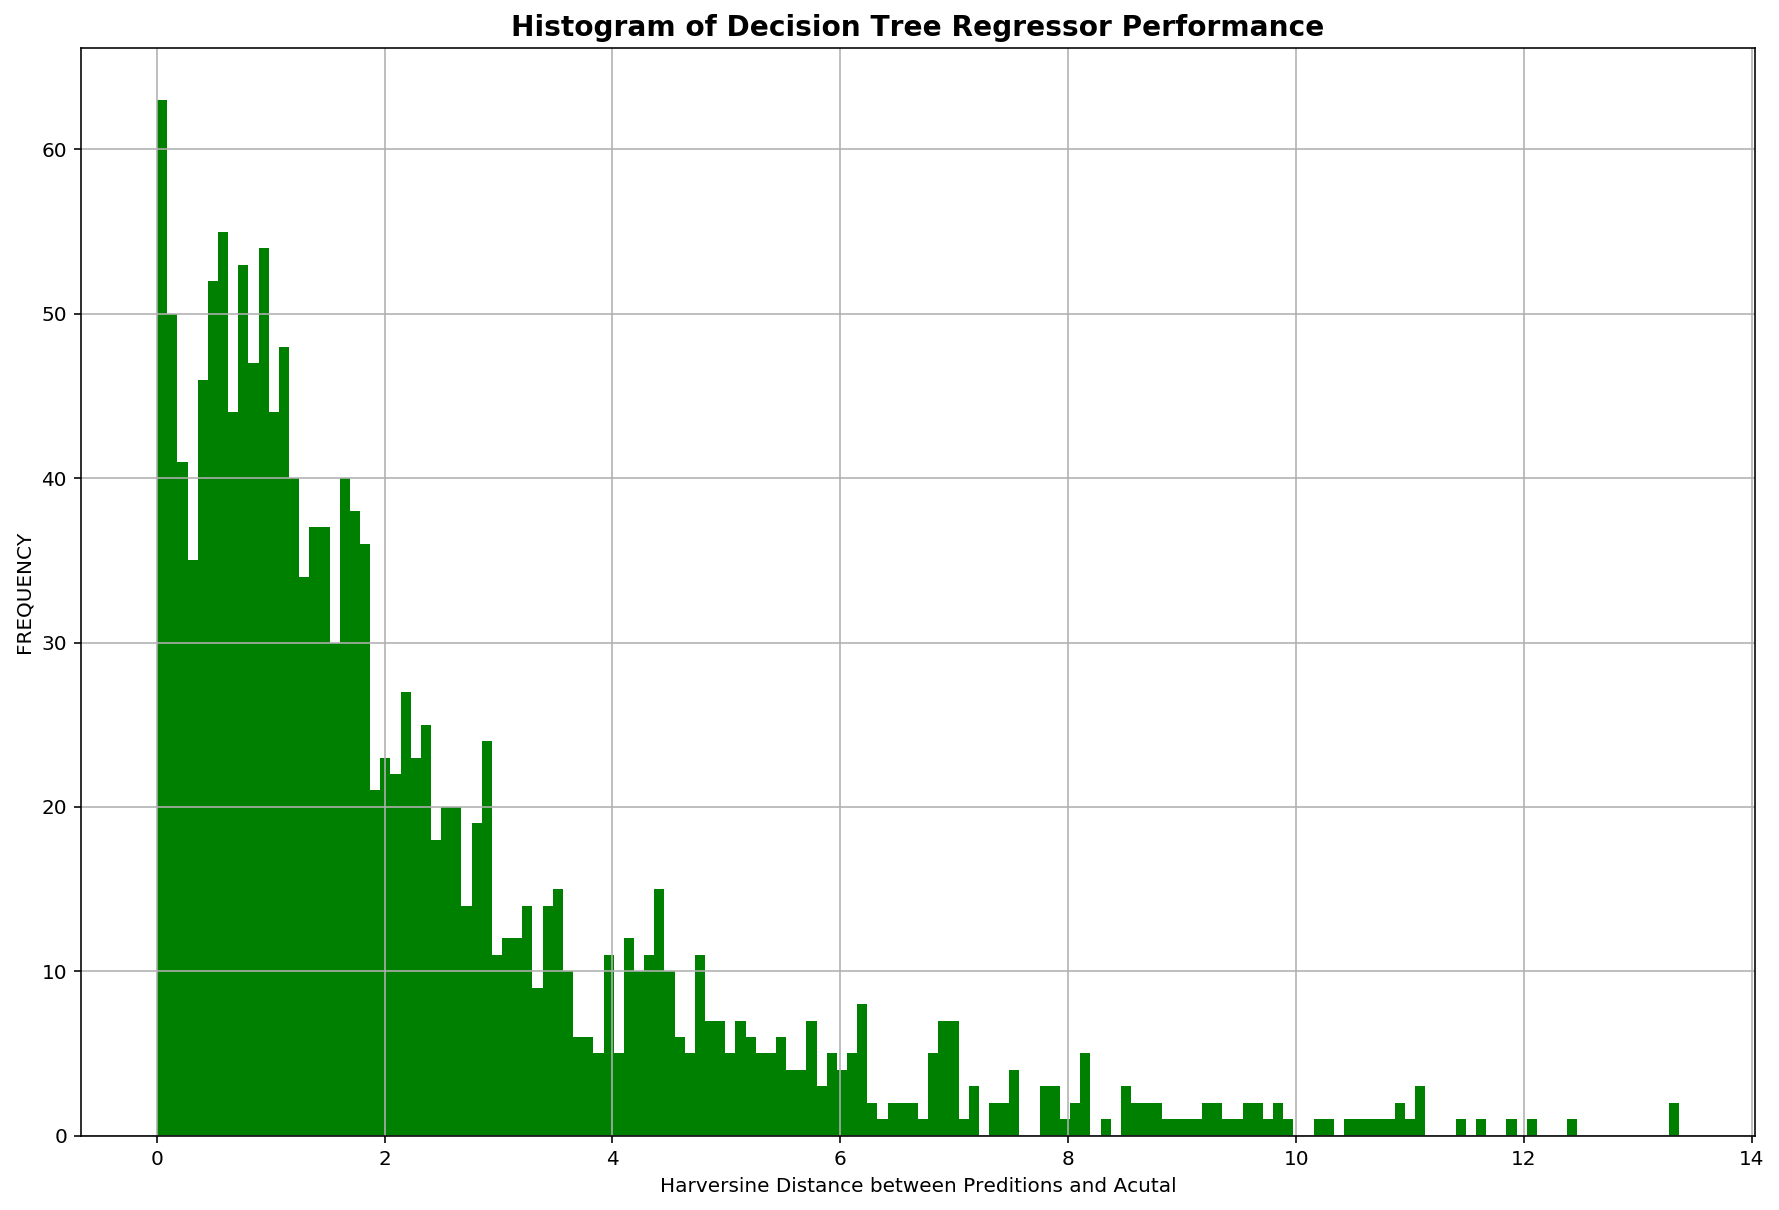

In [23]:
f,ax = plt.subplots(figsize=(15,10))
dtr_score["SCORE"].hist(bins = 150, facecolor='g')
plt.ylabel('FREQUENCY')
plt.xlabel('Harversine Distance between Preditions and Acutal')
plt.title('Histogram of Decision Tree Regressor Performance',fontsize=14, fontweight='bold')

In [89]:
dtr_feature = pd.DataFrame({
        'Features':X_train.columns,
        'Importance':dtr.feature_importances_})

dtr_feature.sort_values('Importance', ascending=False, inplace=True)
dtr_feature.reset_index(drop=True)

,Features,Importance
0,LONG_2_last,7.254916e-01
1,LAT_2_last,2.731898e-01
2,LAT_3_last,2.951968e-04
3,LONG_3_last,2.583361e-04
4,DISTANCE_LOG,2.159380e-04
5,LONG_5_last,1.472774e-04
6,LONG_4_last,1.057417e-04
7,DURATION_LOG,6.684015e-05
8,LAT_5_last,5.627190e-05
9,LAT_4_last,4.194698e-05


As hypothesized, the last subsequent coordinates before a trip ends is most predictive of a taxi ride's destination and our model has also affirmed this as the 2nd and 3rd last coordinates are at the top for feature importance.

# Random Forest Regressor

As DecisionTreeRegressor decides splits based on a greedy algorithm, their accuracy performance might suffer as they tend to overfit the training set. In order to overcome this, we will use a RandomForestRegressor to help generalise the model through bagging techniques. 

With the same DecisionTreeRegressor parameters, a RandomForestRegressor with 200 trees is used.

In [11]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(200, random_state=0, min_samples_split=100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(200, random_state=0, min_samples_split=100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
rfr_val_pred = rfr.predict(X_val)
rfr_df = pd.DataFrame(data = rfr_val_pred, columns=["LATITUDE", "LONGITUDE"])
rfr_score = pd.concat([rfr_df, y_val],axis=1)

rfr_score["SCORE"] = haversine(rfr_score['LATITUDE'],rfr_score['LONGITUDE'], rfr_score['END_LONG'], rfr_score['END_LAT'])

rfr_score['SCORE'] = haversine(rfr_score['LONGITUDE'],rfr_score['LATITUDE'], 
                             rfr_score['END_LONG'], rfr_score['END_LAT'])

In [27]:
print rfr_score['SCORE'].mean()
rfr_score.sort_values("SCORE",ascending=False)

2.0292663431


,LATITUDE,LONGITUDE,END_LAT,END_LONG,SCORE
392,41.131253,-8.613541,41.236740,-8.670024,12.646187
1543,41.145236,-8.578075,41.197806,-8.708985,12.419043
1146,41.143196,-8.610373,41.236371,-8.669970,11.498295
911,41.236759,-8.669991,41.142177,-8.616762,11.421312
1143,41.151590,-8.620500,41.236983,-8.670033,10.360332
303,41.155979,-8.609230,41.236920,-8.670105,10.341494
925,41.148817,-8.586346,41.183577,-8.693820,9.791565
1029,41.149606,-8.674567,41.236731,-8.670006,9.695425
66,41.141982,-8.602866,41.227920,-8.617527,9.634314
1172,41.152891,-8.650735,41.237010,-8.669997,9.491396


As expected, RandomForestRegressor improved our results by reducing the error in distance predicted over 200m.

Text(0.5,1,u'Histogram of Random Forest 200 Performance')

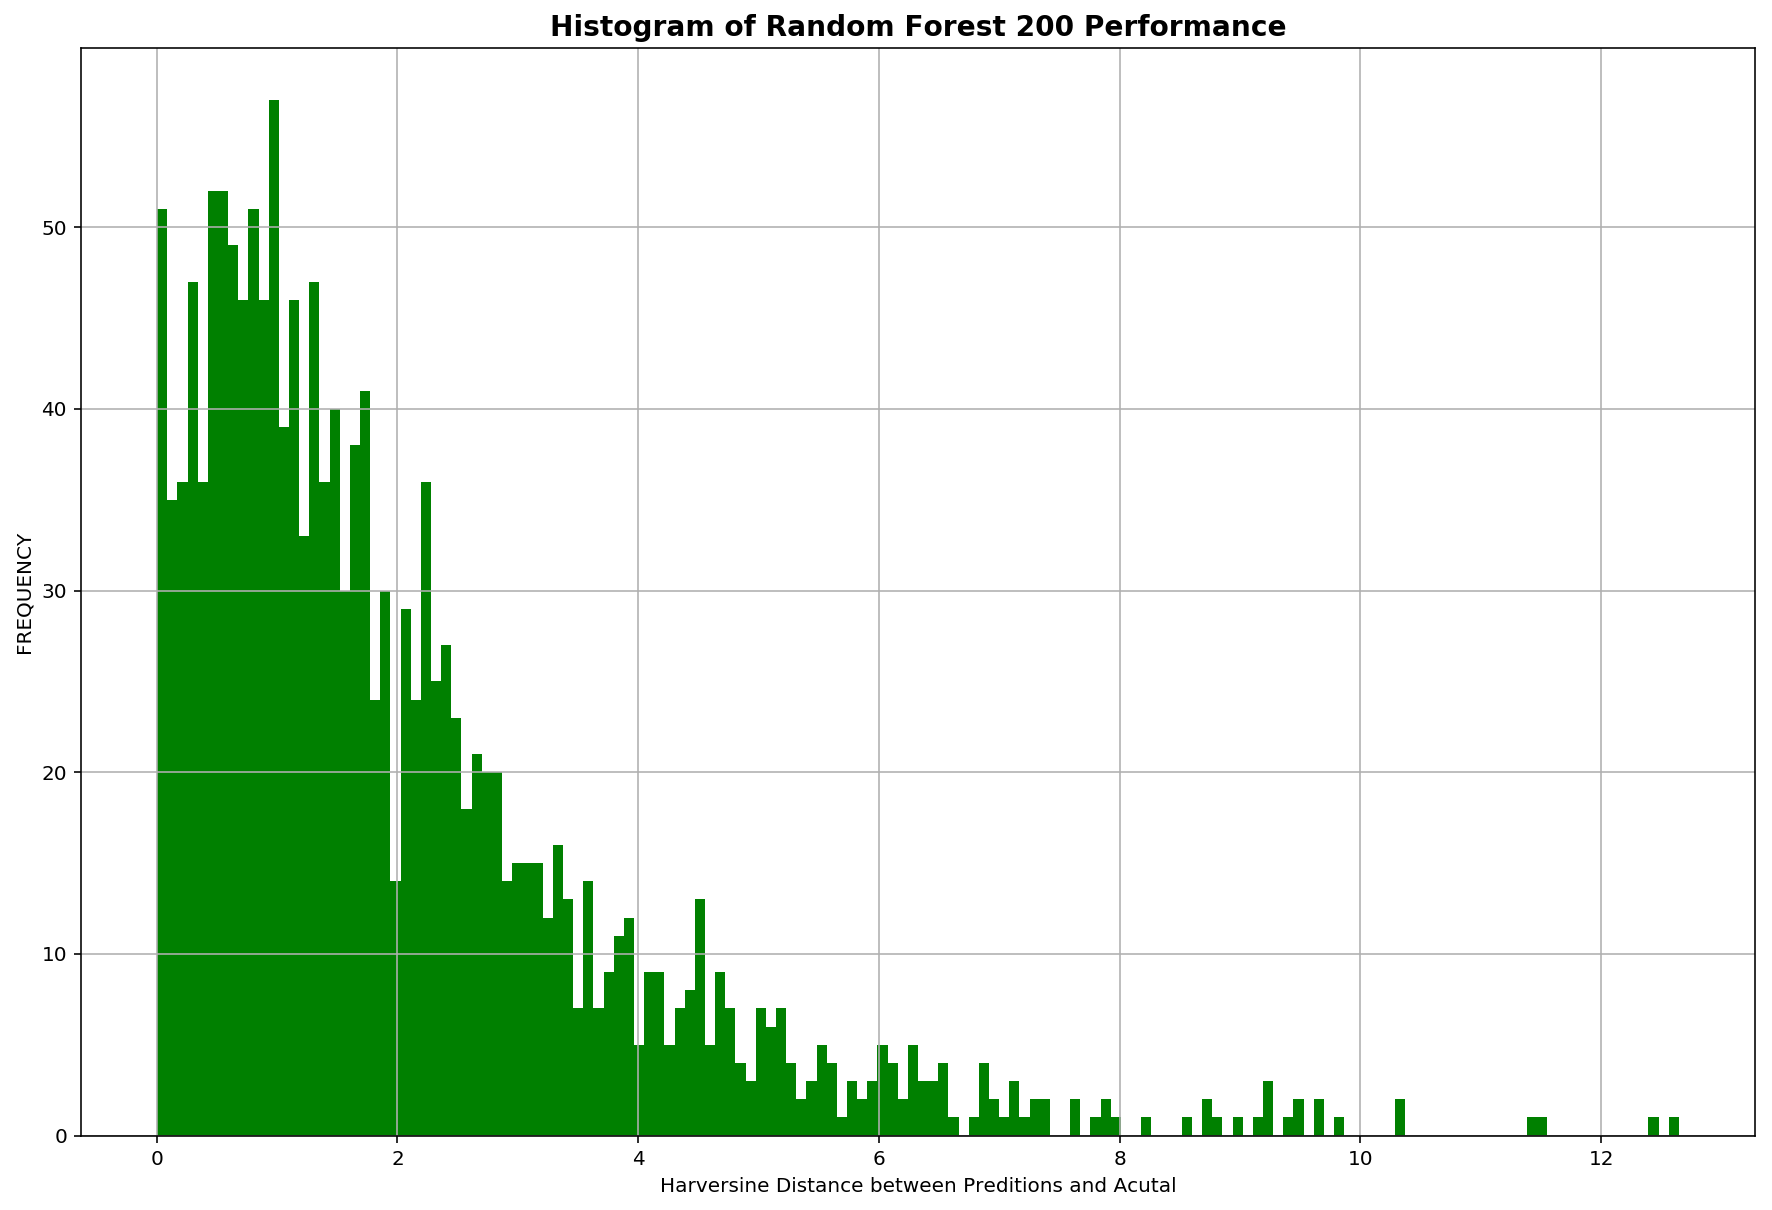

In [17]:
f,ax = plt.subplots(figsize=(15,10))
rfr_score["SCORE"].hist(bins = 150, facecolor='g')
plt.ylabel('FREQUENCY')
plt.xlabel('Harversine Distance between Preditions and Acutal')
plt.title('Histogram of Random Forest 200 Performance',fontsize=14, fontweight='bold')

In [29]:
rfr_feature = pd.DataFrame({
        'Features':X_train.columns,
        'Importance':dtr.feature_importances_})

rfr_feature.sort_values('Importance', ascending=False, inplace=True)
rfr_feature.reset_index(drop=True)

,Features,Importance
0,LONG_2_last,7.254916e-01
1,LAT_2_last,2.731898e-01
2,LAT_3_last,2.951968e-04
3,LONG_3_last,2.583361e-04
4,DISTANCE_LOG,2.159380e-04
5,LONG_5_last,1.472774e-04
6,LONG_4_last,1.057417e-04
7,DURATION_LOG,6.684015e-05
8,LAT_5_last,5.627190e-05
9,LAT_4_last,4.194698e-05


### Predicting on Kaggle's testset

In [99]:
dtr_test_pred = dtr.predict(test)
dtr_df_test = pd.DataFrame(data = dtr_test_pred, columns=["LATITUDE", "LONGITUDE"])

rfr_test_pred = rfr.predict(test)
rfr_df_test = pd.DataFrame(data = rfr_test_pred, columns=["LATITUDE", "LONGITUDE"])

In [100]:
dtr_df_test.to_csv('./test_results/dtr100.csv')
rfr_df_test.to_csv('./test_results/rfr200.csv')

Public score of 2.93471 #100/381 position on public leaderboard  
Private score of 2.84788 #244/381 position on private leaderboard